In [1]:
import os
#import cv2
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
#import seaborn as sns

#from sklearn.metrics import classification_report, confusion_matrix

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
from tqdm import tqdm
import os
import collections
import pandas as pd
metadata = pd.read_csv('data_xray/Data_Entry_2017_v2020.csv')
list_dir = os.listdir('data_xray/images/')
count = 0
missing_imgs = []
print('Original datashape', metadata.shape)
for img in tqdm(metadata['Image Index']):
    if img not in list_dir:
        count+=1
        missing_imgs.append(img)

# metadata = metadata[~(metadata['Image Index']==img)]
metadata_ = metadata[~metadata['Image Index'].isin(missing_imgs)]
print('Processed datashape', metadata_.shape)
print('Removed %s rows from df'%(count))

print('Images with NO label:', collections.Counter(metadata_['Finding Labels'])['No Finding'])

FileNotFoundError: [Errno 2] No such file or directory: 'data_xray/Data_Entry_2017_v2020.csv'

In [23]:
# Dataframe with no 'No finding' labels
indices = metadata_[metadata_['Finding Labels']=='No Finding'].index
metadata_.drop(indices , inplace=True)

/home/yogesh/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
metadata_.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168


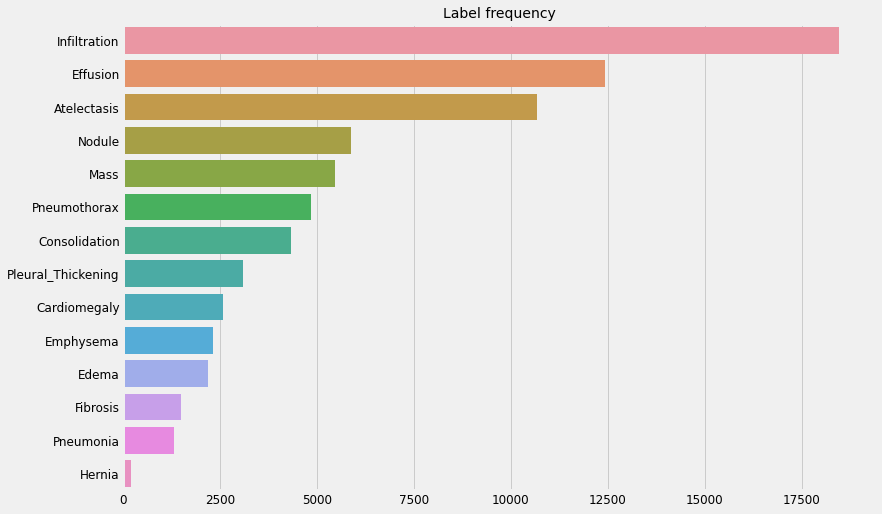

We will be ignoring these rare labels: ['Hernia']


/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,[Cardiomegaly],0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168
4,00000003_001.png,[],0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,[],1,3,75,F,PA,2048,2500,0.168,0.168


In [25]:
# Get label frequencies in descending order
label_freq = metadata_['Finding Labels'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Create a list of rare labels
rare = list(label_freq[label_freq<500].index)
print("We will be ignoring these rare labels:", rare)

# Transform diseases into a list of labels and remove the rare ones
metadata_['Finding Labels'] = metadata_['Finding Labels'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
metadata_.head()

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

X_train, X_val, y_train, y_val = train_test_split(metadata_['Image Index'], metadata_['Finding Labels'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  38206
Number of posters for validation:  9552


In [27]:
img_folder = 'data_xray/images/'
len(os.listdir(img_folder))

102120

In [28]:
X_train = [os.path.join(img_folder, str(f)) for f in X_train]
X_val = [os.path.join(img_folder, str(f)) for f in X_val]
print(X_train[:3])

y_train = list(y_train)
y_val = list(y_val)
print(y_train[:3])

['/storage_nvme2/yogesh/JKD/data_xray/images/00009021_014.png', '/storage_nvme2/yogesh/JKD/data_xray/images/00010648_006.png', '/storage_nvme2/yogesh/JKD/data_xray/images/00016006_003.png']
[['Pleural_Thickening'], ['Pleural_Thickening'], ['Pleural_Thickening']]


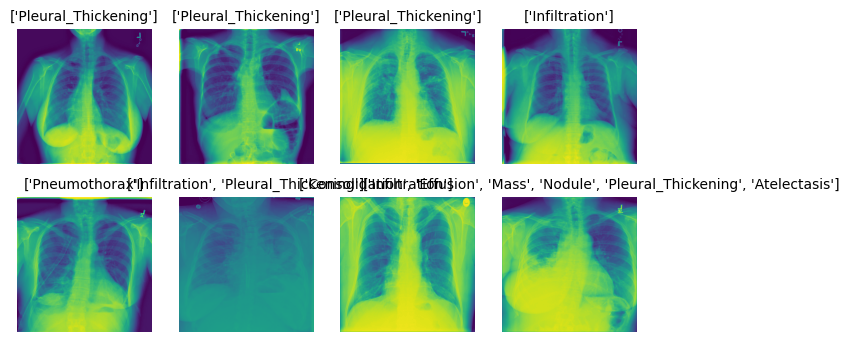

In [29]:
from PIL import Image
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(8,2*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

In [30]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. Atelectasis
1. Cardiomegaly
2. Consolidation
3. Edema
4. Effusion
5. Emphysema
6. Fibrosis
7. Infiltration
8. Mass
9. Nodule
10. Pleural_Thickening
11. Pneumonia
12. Pneumothorax


In [31]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

# Print example of Xray images and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

/storage_nvme2/yogesh/JKD/data_xray/images/00009021_014.png [0 0 0 0 0 0 0 0 0 0 1 0 0]
/storage_nvme2/yogesh/JKD/data_xray/images/00010648_006.png [0 0 0 0 0 0 0 0 0 0 1 0 0]
/storage_nvme2/yogesh/JKD/data_xray/images/00016006_003.png [0 0 0 0 0 0 0 0 0 0 1 0 0]


In [32]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [33]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [34]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 13)


In [37]:
import tensorflow_hub as hub

mobilenet_v2 = tf.keras.models.load_model('pretrained_models/imagenet_mobilenet_v2_100_224_classification_5')
feature_extractor_layer = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_v2, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
])

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1001)              3540265   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1026048   
_________________________________________________________________
output (Dense)               (None, 13)                13325     
Total params: 4,579,638
Trainable params: 1,039,373
Non-trainable params: 3,540,265
_________________________________________________________________


In [38]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.3075463  0.34047422 0.8584973  0.25719967 0.32942492 0.8550726
  0.52579856 0.81929535 0.5467948  0.65752023 0.70176613 0.56932473
  0.15510713]]


In [39]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [40]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 50

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

from datetime import time
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/50
150/150 [==============================] - 36s 212ms/step - loss: 0.8002 - macro_f1: 0.2050 - val_loss: 0.7886 - val_macro_f1: 0.2195
Epoch 2/50
150/150 [==============================] - 30s 198ms/step - loss: 0.7797 - macro_f1: 0.2342 - val_loss: 0.7736 - val_macro_f1: 0.2438
Epoch 3/50
150/150 [==============================] - 21s 139ms/step - loss: 0.7657 - macro_f1: 0.2533 - val_loss: 0.7619 - val_macro_f1: 0.2569
Epoch 4/50
150/150 [==============================] - 21s 140ms/step - loss: 0.7559 - macro_f1: 0.2632 - val_loss: 0.7544 - val_macro_f1: 0.2625
Epoch 5/50
150/150 [==============================] - 21s 142ms/step - loss: 0.7488 - macro_f1: 0.2688 - val_loss: 0.7483 - val_macro_f1: 0.2671
Epoch 6/50
150/150 [==============================] - 21s 141ms/step - loss: 0.7433 - macro_f1: 0.2741 - val_loss: 0.7440 - val_macro_f1: 0.2720
Epoch 7/50
150/150 [==============================] - 21s 139ms/step - loss: 0.7388 - macro_f1: 0.2790 - val_loss: 0.7405 - val_ma

NameError: name 'print_time' is not defined

History keys: dict_keys(['loss', 'macro_f1', 'val_loss', 'val_macro_f1'])


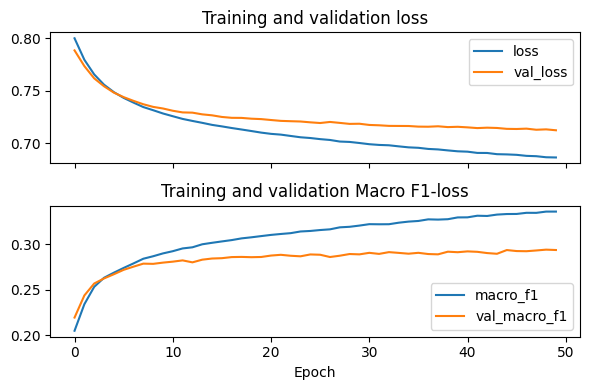

In [41]:
import matplotlib.pyplot as plt
print('History keys:', history.history.keys())
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
   
ax[0].plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
ax[0].plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
ax[0].set_title('Training and validation loss')

ax[1].plot(range(len(history.history['macro_f1'])),history.history['macro_f1'], label='macro_f1')
ax[1].plot(range(len(history.history['val_macro_f1'])),history.history['val_macro_f1'], label='val_macro_f1')
ax[1].set_title('Training and validation Macro F1-loss')
ax[1].set_xlabel('Epoch')

ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [42]:
# Train model with BCE
from utils import *
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
150/150 [==============================] - 28s 179ms/step - loss: 0.3717 - macro_f1: 0.0708 - val_loss: 0.3246 - val_macro_f1: 0.0691
Epoch 2/50
150/150 [==============================] - 23s 152ms/step - loss: 0.3178 - macro_f1: 0.0694 - val_loss: 0.3133 - val_macro_f1: 0.0668
Epoch 3/50
150/150 [==============================] - 23s 153ms/step - loss: 0.3099 - macro_f1: 0.0765 - val_loss: 0.3084 - val_macro_f1: 0.0785
Epoch 4/50
150/150 [==============================] - 22s 144ms/step - loss: 0.3057 - macro_f1: 0.0806 - val_loss: 0.3058 - val_macro_f1: 0.0807
Epoch 5/50
150/150 [==============================] - 22s 146ms/step - loss: 0.3031 - macro_f1: 0.0838 - val_loss: 0.3038 - val_macro_f1: 0.0819
Epoch 6/50
150/150 [==============================] - 21s 141ms/step - loss: 0.3013 - macro_f1: 0.0860 - val_loss: 0.3028 - val_macro_f1: 0.0857
Epoch 7/50
150/150 [==============================] - 22s 148ms/step - loss: 0.3000 - macro_f1: 0.0890 - val_loss: 0.3022 - val_ma

History keys: dict_keys(['loss', 'macro_f1', 'val_loss', 'val_macro_f1'])


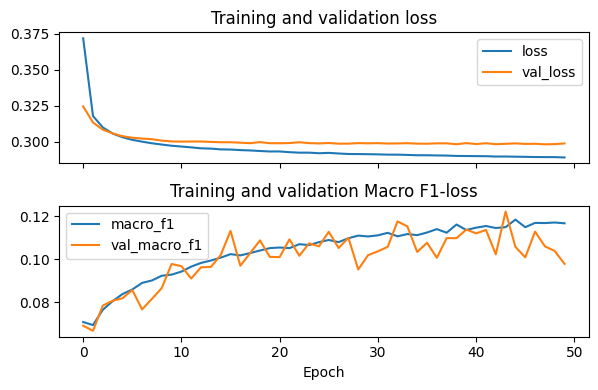

In [44]:
import matplotlib.pyplot as plt
print('History keys:', history_bce.history.keys())
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
   
ax[0].plot(range(len(history_bce.history['loss'])),history_bce.history['loss'], label='loss')
ax[0].plot(range(len(history_bce.history['val_loss'])),history_bce.history['val_loss'], label='val_loss')
ax[0].set_title('Training and validation loss')

ax[1].plot(range(len(history_bce.history['macro_f1'])),history_bce.history['macro_f1'], label='macro_f1')
ax[1].plot(range(len(history_bce.history['val_macro_f1'])),history_bce.history['val_macro_f1'], label='val_macro_f1')
ax[1].set_title('Training and validation Macro F1-loss')
ax[1].set_xlabel('Epoch')

ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [45]:
from utils import perf_grid
# Get all label names
label_names = mlb.classes_
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(val_ds, y_val_bin, label_names, model)
# Performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

In [46]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,Atelectasis,0.22,0.00,2106,0,7446,0.220477,1.000000,0.361297
1,0,Atelectasis,0.22,0.01,2106,0,7442,0.220570,1.000000,0.361421
2,0,Atelectasis,0.22,0.02,2088,18,7381,0.220509,0.991453,0.360778
3,0,Atelectasis,0.22,0.03,2054,52,7253,0.220694,0.975309,0.359940
4,0,Atelectasis,0.22,0.04,2001,105,7066,0.220690,0.950142,0.358185


In [47]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,7,Infiltration,0.380000,0.554370
1,4,Effusion,0.260000,0.418909
2,0,Atelectasis,0.220000,0.361421
3,9,Nodule,0.120000,0.216656
4,8,Mass,0.120000,0.206871
5,12,Pneumothorax,0.110000,0.191765
6,2,Consolidation,0.090000,0.160308
7,10,Pleural_Thickening,0.070000,0.127494
8,1,Cardiomegaly,0.060000,0.107942
9,5,Emphysema,0.050000,0.095694


In [48]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))

Correlation between label frequency and optimal F1 with bce: 1.00


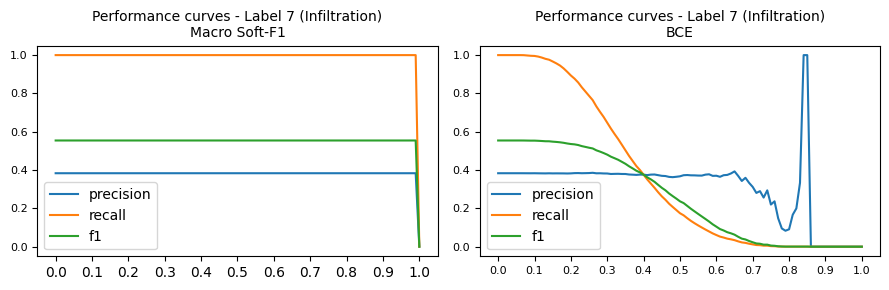

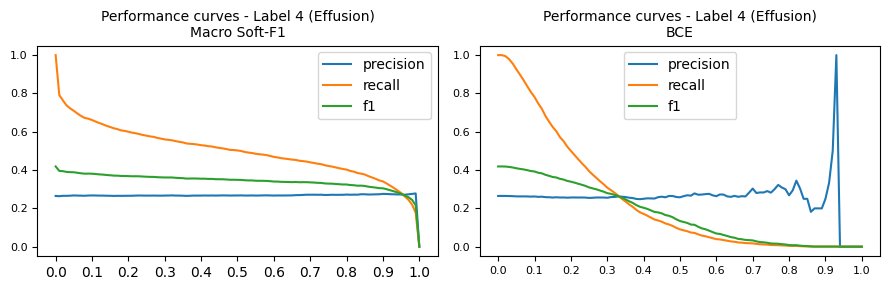

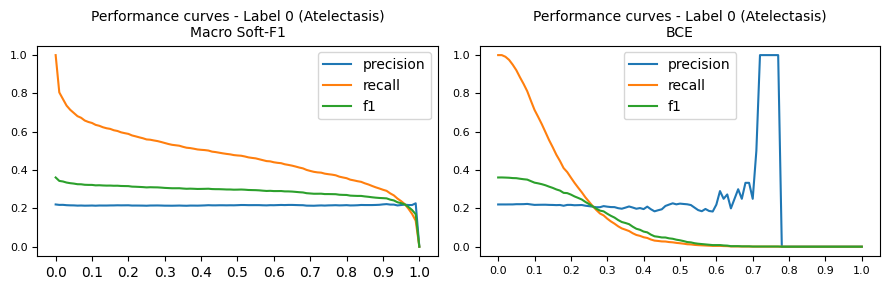

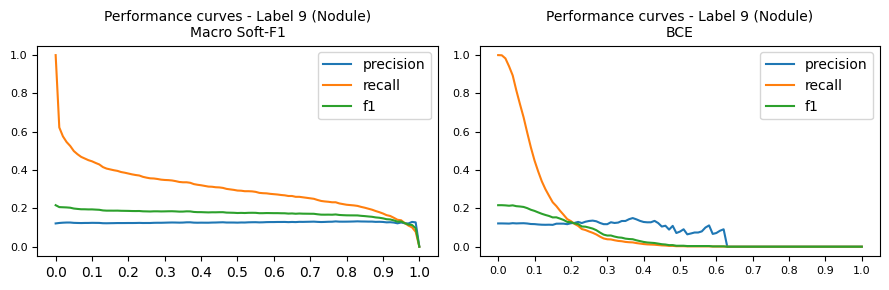

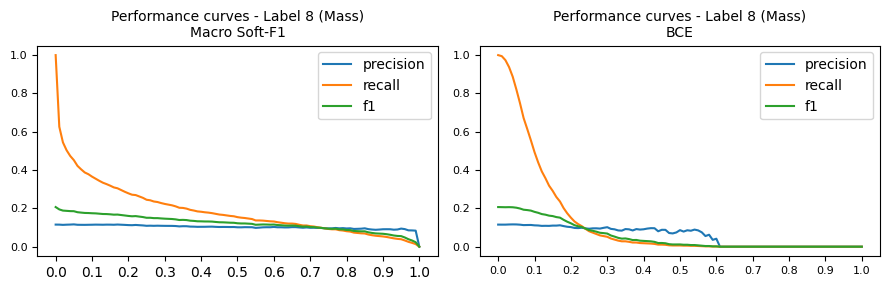

In [49]:
top5 = max_perf.head(5)['id']
style.use("default")
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()


/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


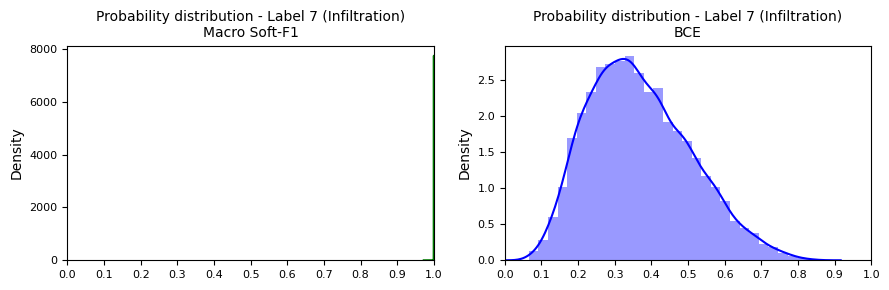

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


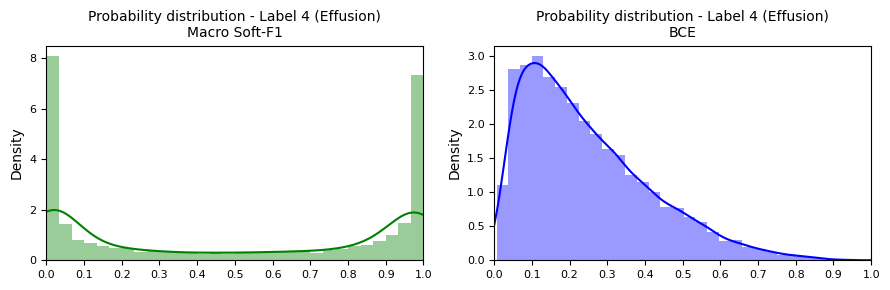

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


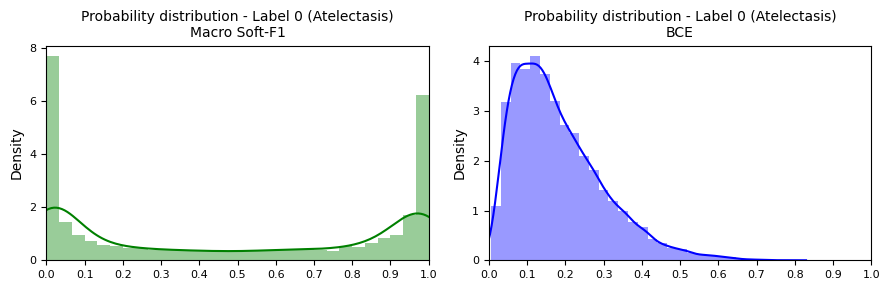

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


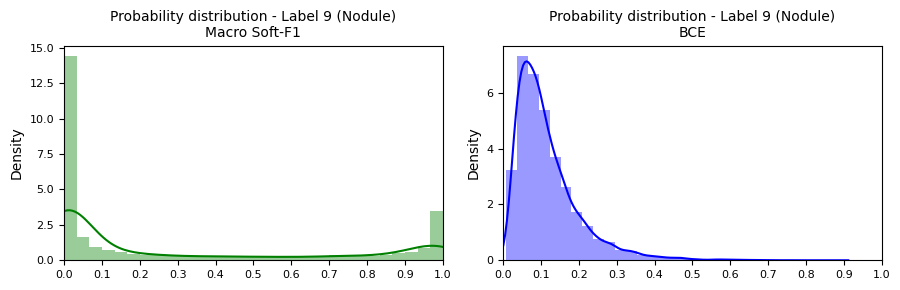

/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yogesh/miniconda3/envs/xray_tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


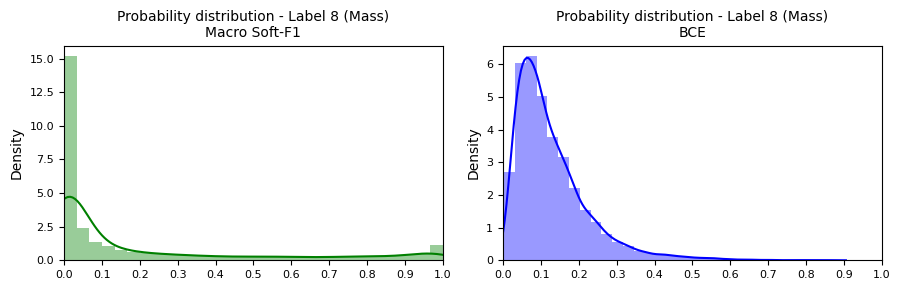

In [50]:
# Probability distribution
# Predict on the validation set with both models
y_hat_val = model.predict(val_ds)
y_hat_val_bce = model_bce.predict(val_ds)

style.use("default")
for l in top5:
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val[:,l], bins=30, kde=True, color="g")
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()
    

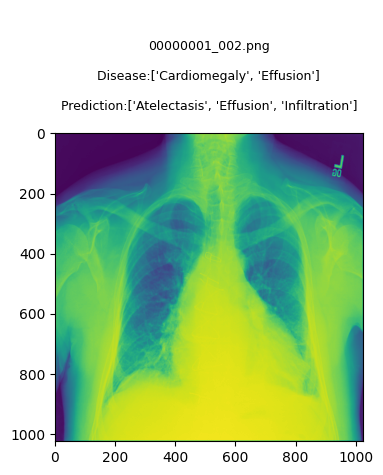

In [51]:
#def show_prediction(image_id, metadata_, model):
    #print(image_id, metadata_df)
    # Get movie info
    
from keras.preprocessing import image
img_id = '00000001_002.png'

true_label = metadata_.loc[metadata_['Image Index']==img_id]['Finding Labels'].iloc[0]
img_path = os.path.join(img_folder, str(img_id))

# Read and prepare image
img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)

# Generate prediction
prediction = (model.predict(img) > 0.5).astype('int')
prediction = pd.Series(prediction[0])
prediction.index = mlb.classes_
prediction = prediction[prediction==1].index.values

# Dispaly image with prediction
style.use('default')
plt.figure(figsize=(8,4))
plt.imshow(Image.open(img_path))
plt.title('\n\n{}\n\nDisease:{}\n\nPrediction:{}\n'.format(img_id, true_label, list(prediction)), fontsize=9)
plt.show()